# Importing necessary libraries and data


In [1]:
import cv2
import os
import numpy as np
import pandas as pd
from random import seed
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
X = np.load('data2.npy')
Y = np.load('label2.npy')

In [3]:
print(X.shape)
print(Y.shape)

(3662, 224, 224, 3)
(3662,)


In [4]:
df_train = pd.read_csv('E:/Dataset/DR/train.csv')
train_dir = 'E:/Dataset/DR/train_images/'

img_size =224

# Explorative Data Analysis

In [5]:
unique, counts = np.unique(Y, return_counts=True)
LabelCounts = dict(zip(unique, counts))

for key, value in LabelCounts.items():
    if(key==0):
        print(key, '(No DR) : ', value)
    
    elif(key==1):
        print(key, '(Mild) : ', value)
    
    elif(key==2):
        print(key, '(Moderate) : ', value)
        
    elif(key==3):
        print(key, '(Severe) : ', value)
    
    else:
        print(key, '(Proliferative DR) : ', value)

0 (No DR) :  1805
1 (Mild) :  370
2 (Moderate) :  999
3 (Severe) :  193
4 (Proliferative DR) :  295


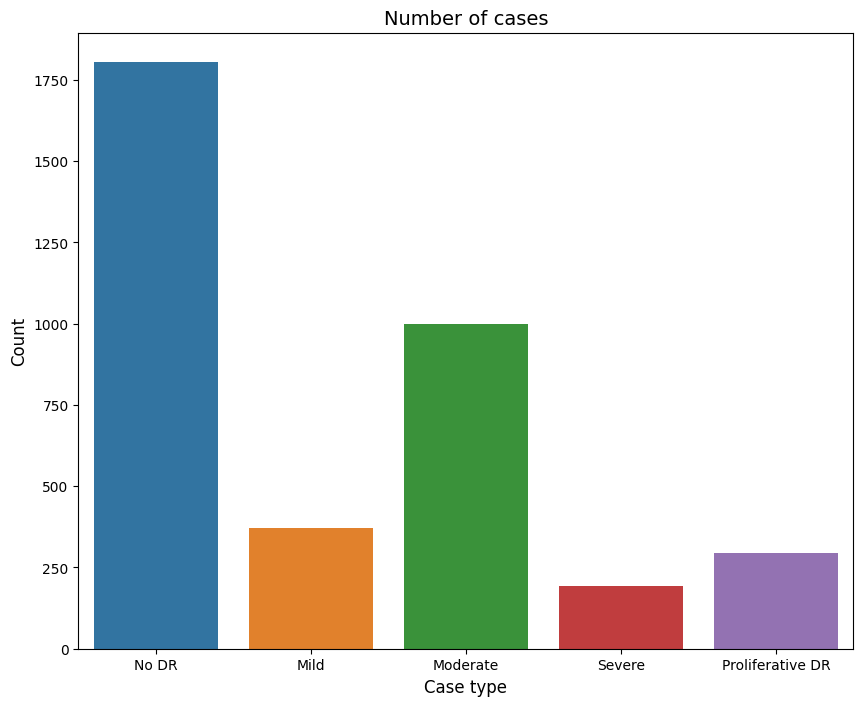

In [6]:
plt.figure(figsize=(10,8))
sns.barplot(x=unique, y= counts)
plt.title('Number of cases', fontsize=14)
plt.xlabel('Case type', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(range(len(unique)), ['No DR', 'Mild','Moderate','Severe', 'Proliferative DR' ])
plt.show()

In [7]:
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight(class_weight = "balanced", classes = np.unique(Y), y = Y)
class_weights = dict(zip(np.unique(Y), class_weights))
class_weights

{0: 0.4057617728531856,
 1: 1.9794594594594594,
 2: 0.7331331331331331,
 3: 3.7948186528497407,
 4: 2.4827118644067796}

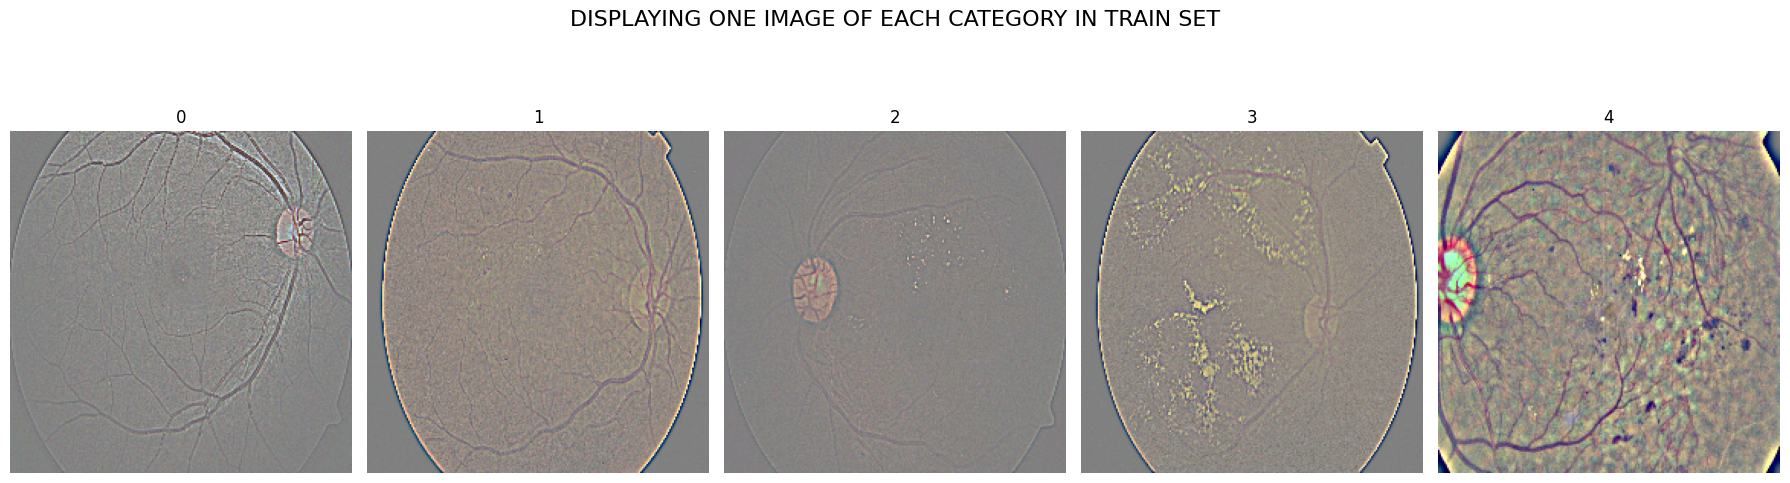

In [8]:
fig, ax= plt.subplots(nrows= 1, ncols= 5, figsize= (18,5))
plt.suptitle('displaying one image of each category in train set'.upper(), 
             y= 1.05, fontsize= 16)

for i in sorted(np.unique(Y)):
    X_image = X[list(Y).index(i)]
    
    ax[i].imshow(X_image)
    ax[i].axis('off')
    ax[i].set_title(i)

plt.tight_layout()
plt.show()

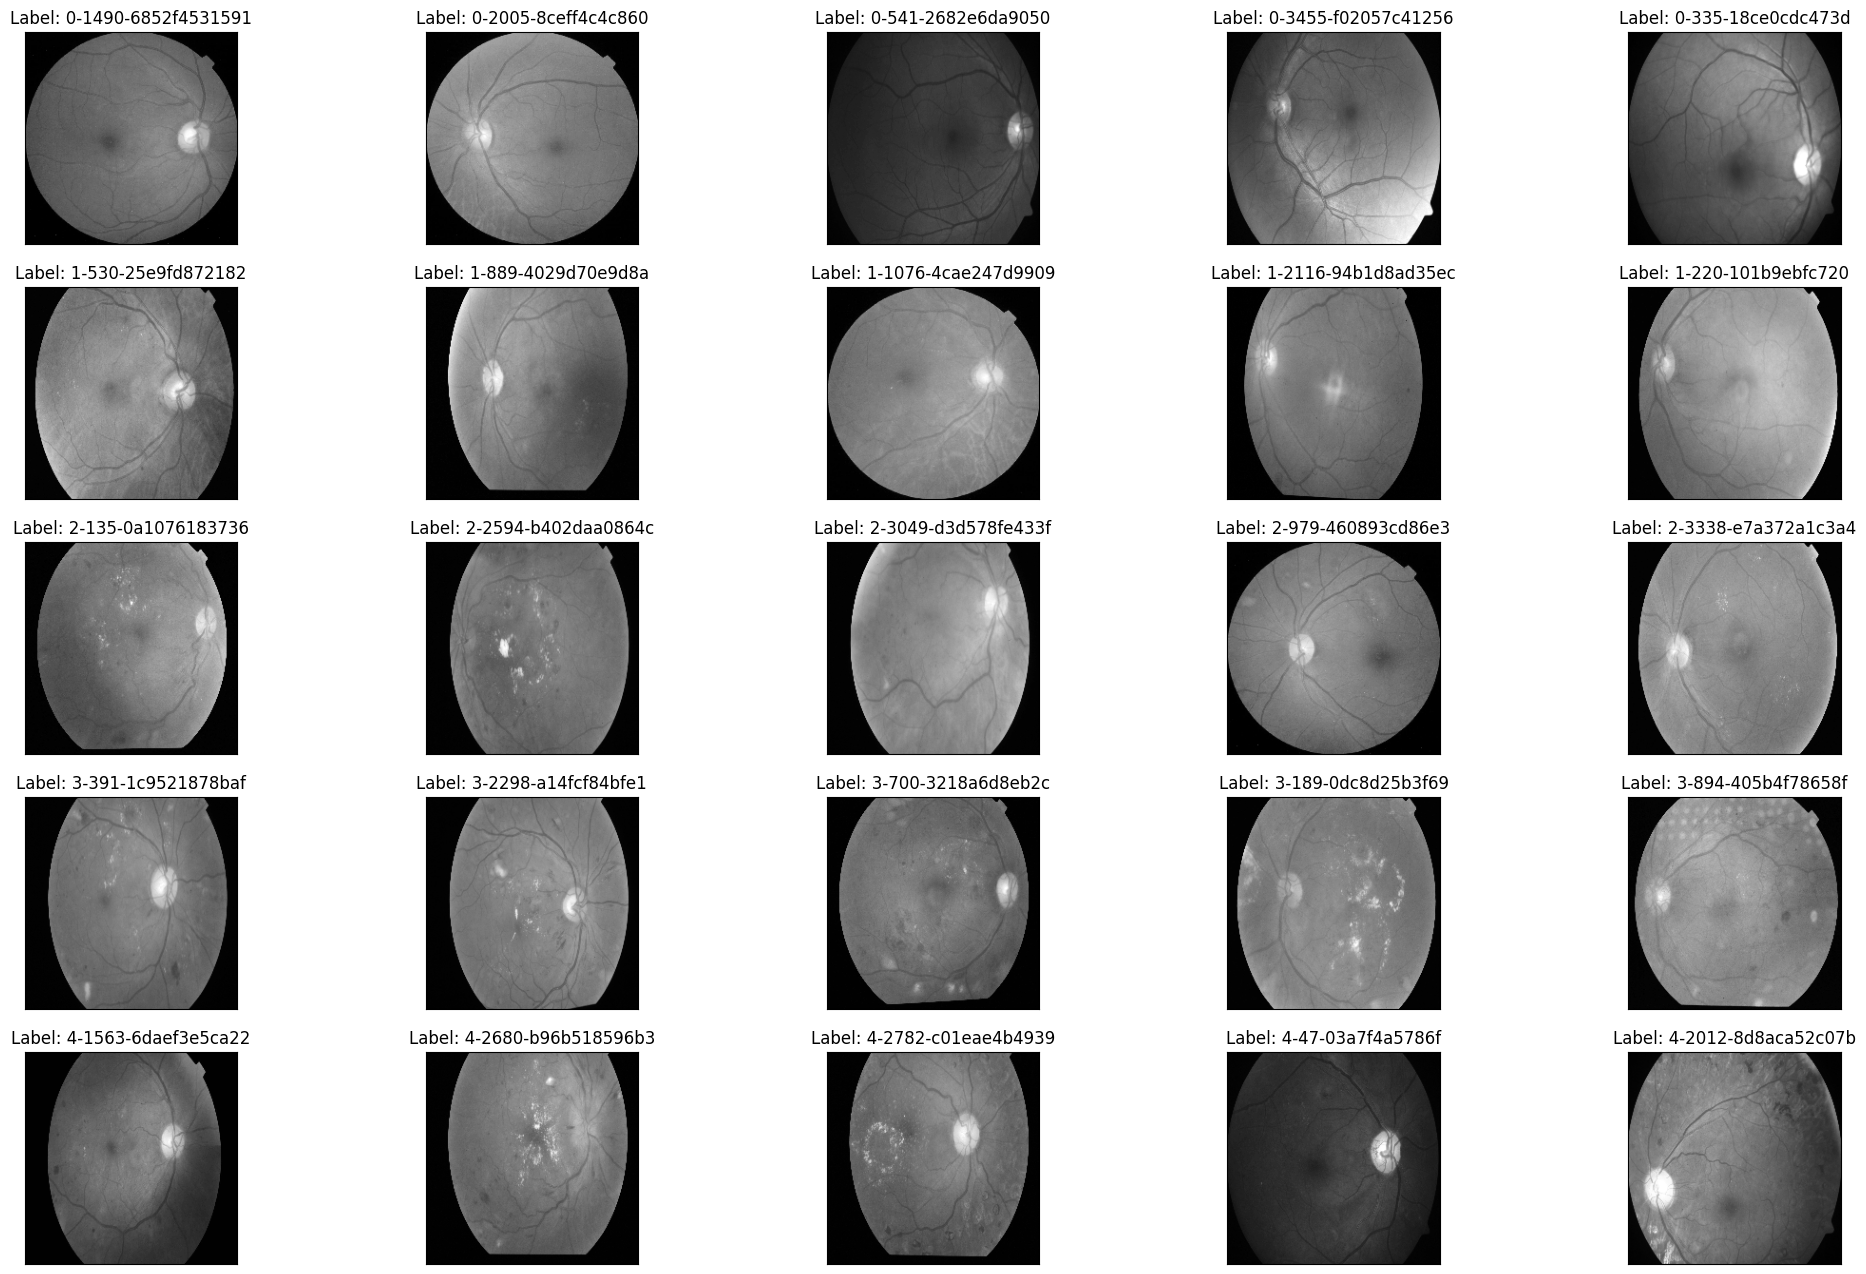

In [9]:
fig = plt.figure(figsize=(25, 16))
# display 10 images from each class
for class_id in sorted(np.unique(Y)):
    for i, (idx, row) in enumerate(df_train.loc[df_train['diagnosis'] == class_id].sample(5, random_state=2).iterrows()):
        ax = fig.add_subplot(5, 5, class_id * 5 + i + 1, xticks=[], yticks=[])
        path=f"{train_dir}{row['id_code']}.png"
        image = cv2.imread(path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        image = cv2.resize(image, (img_size, img_size))

        plt.imshow(image, cmap="gray")
        ax.set_title('Label: %d-%d-%s' % (class_id, idx, row['id_code']) )

# Data Augmentation

In [10]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [11]:
auggen = ImageDataGenerator(
        rotation_range=20,       # Rotate by up to 20 degrees
        width_shift_range=0.1,  # Shift width by 10%
        height_shift_range=0.1, # Shift height by 10%
        #shear_range=0.2,        # Shear transformation
        zoom_range=0.2,         # Zoom in or out by 20%
        horizontal_flip=True,   # Flip horizontally
        #vertical_flip=True,     # Flip vertically
        #brightness_range=(0.8, 1.2), # Random brightness adjustments
        #fill_mode='nearest'     # Filling mode for pixel values
        )  

### Split the data into train, test and validation sets

In [12]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, shuffle=True)

#X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.3, shuffle=True)

In [13]:
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(2929, 224, 224, 3)
(733, 224, 224, 3)


# Transfer Learning 


In [14]:
import tensorflow as tf

from sklearn.metrics import classification_report,confusion_matrix
from tensorflow.keras.utils import to_categorical

from efficientnet.tfkeras import EfficientNetB7

from keras.applications.inception_v3 import InceptionV3 
from tensorflow.keras.applications.inception_v3 import preprocess_input

from keras.applications.resnet import ResNet50

from tensorflow.keras.optimizers import Adam,RMSprop
from keras.regularizers import l2,l1

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten , Dropout , BatchNormalization , GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

from tensorflow import keras
from sklearn import svm
from sklearn.metrics import accuracy_score

### Importing base model 


In [15]:
baseModel = InceptionV3(weights="imagenet", include_top=False, input_shape=(img_size, img_size, 3))

In [16]:
baseModel.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 111, 111, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 111, 111, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                      

 batch_normalization_5 (BatchNo  (None, 25, 25, 64)  192         ['conv2d_5[0][0]']               
 rmalization)                                                                                     
                                                                                                  
 batch_normalization_7 (BatchNo  (None, 25, 25, 64)  192         ['conv2d_7[0][0]']               
 rmalization)                                                                                     
                                                                                                  
 batch_normalization_10 (BatchN  (None, 25, 25, 96)  288         ['conv2d_10[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 batch_normalization_11 (BatchN  (None, 25, 25, 32)  96          ['conv2d_11[0][0]']              
 ormalizat

                                                                                                  
 batch_normalization_22 (BatchN  (None, 25, 25, 64)  192         ['conv2d_22[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_22 (Activation)     (None, 25, 25, 64)   0           ['batch_normalization_22[0][0]'] 
                                                                                                  
 conv2d_20 (Conv2D)             (None, 25, 25, 48)   13824       ['mixed1[0][0]']                 
                                                                                                  
 conv2d_23 (Conv2D)             (None, 25, 25, 96)   55296       ['activation_22[0][0]']          
                                                                                                  
 batch_nor

                                                                                                  
 max_pooling2d_2 (MaxPooling2D)  (None, 12, 12, 288)  0          ['mixed2[0][0]']                 
                                                                                                  
 mixed3 (Concatenate)           (None, 12, 12, 768)  0           ['activation_26[0][0]',          
                                                                  'activation_29[0][0]',          
                                                                  'max_pooling2d_2[0][0]']        
                                                                                                  
 conv2d_34 (Conv2D)             (None, 12, 12, 128)  98304       ['mixed3[0][0]']                 
                                                                                                  
 batch_normalization_34 (BatchN  (None, 12, 12, 128)  384        ['conv2d_34[0][0]']              
 ormalizat

                                                                  'activation_39[0][0]']          
                                                                                                  
 conv2d_44 (Conv2D)             (None, 12, 12, 160)  122880      ['mixed4[0][0]']                 
                                                                                                  
 batch_normalization_44 (BatchN  (None, 12, 12, 160)  480        ['conv2d_44[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_44 (Activation)     (None, 12, 12, 160)  0           ['batch_normalization_44[0][0]'] 
                                                                                                  
 conv2d_45 (Conv2D)             (None, 12, 12, 160)  179200      ['activation_44[0][0]']          
          

 ormalization)                                                                                    
                                                                                                  
 activation_54 (Activation)     (None, 12, 12, 160)  0           ['batch_normalization_54[0][0]'] 
                                                                                                  
 conv2d_55 (Conv2D)             (None, 12, 12, 160)  179200      ['activation_54[0][0]']          
                                                                                                  
 batch_normalization_55 (BatchN  (None, 12, 12, 160)  480        ['conv2d_55[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_55 (Activation)     (None, 12, 12, 160)  0           ['batch_normalization_55[0][0]'] 
          

                                                                                                  
 batch_normalization_65 (BatchN  (None, 12, 12, 192)  576        ['conv2d_65[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_65 (Activation)     (None, 12, 12, 192)  0           ['batch_normalization_65[0][0]'] 
                                                                                                  
 conv2d_61 (Conv2D)             (None, 12, 12, 192)  147456      ['mixed6[0][0]']                 
                                                                                                  
 conv2d_66 (Conv2D)             (None, 12, 12, 192)  258048      ['activation_65[0][0]']          
                                                                                                  
 batch_nor

                                                                                                  
 conv2d_70 (Conv2D)             (None, 12, 12, 192)  147456      ['mixed7[0][0]']                 
                                                                                                  
 conv2d_74 (Conv2D)             (None, 12, 12, 192)  258048      ['activation_73[0][0]']          
                                                                                                  
 batch_normalization_70 (BatchN  (None, 12, 12, 192)  576        ['conv2d_70[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 batch_normalization_74 (BatchN  (None, 12, 12, 192)  576        ['conv2d_74[0][0]']              
 ormalization)                                                                                    
          

 batch_normalization_76 (BatchN  (None, 5, 5, 320)   960         ['conv2d_76[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_78 (Activation)     (None, 5, 5, 384)    0           ['batch_normalization_78[0][0]'] 
                                                                                                  
 activation_79 (Activation)     (None, 5, 5, 384)    0           ['batch_normalization_79[0][0]'] 
                                                                                                  
 activation_82 (Activation)     (None, 5, 5, 384)    0           ['batch_normalization_82[0][0]'] 
                                                                                                  
 activation_83 (Activation)     (None, 5, 5, 384)    0           ['batch_normalization_83[0][0]'] 
          

                                                                                                  
 activation_91 (Activation)     (None, 5, 5, 384)    0           ['batch_normalization_91[0][0]'] 
                                                                                                  
 activation_92 (Activation)     (None, 5, 5, 384)    0           ['batch_normalization_92[0][0]'] 
                                                                                                  
 batch_normalization_93 (BatchN  (None, 5, 5, 192)   576         ['conv2d_93[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_85 (Activation)     (None, 5, 5, 320)    0           ['batch_normalization_85[0][0]'] 
                                                                                                  
 mixed9_1 

loop over all layers in the base model and freeze them so they will not be updated during the first training process

In [17]:
for layer in baseModel.layers:
    layer.trainable = False

construct the new model by adding base model then fully connected layers and output

In [18]:
model = Sequential()
model.add(baseModel)
model.add(Flatten())
model.add(Dropout(0.2))
model.add(Dense(5, activation='softmax')) 

Compling our final model

In [19]:
model.compile(optimizer=RMSprop(learning_rate=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [20]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 flatten (Flatten)           (None, 51200)             0         
                                                                 
 dense (Dense)               (None, 1024)              52429824  
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 5)                 5125      
                                                                 
Total params: 74,237,733
Trainable params: 52,434,949
Non-trainable params: 21,802,784
_________________________________________________________________


Decrease learning rate when model converges 

In [21]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1, factor=0.2)

In [22]:
callback = [EarlyStopping(monitor = 'val_loss' , patience=10, restore_best_weights=True)
          , ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, min_lr=1e-8 , verbose=1)]

# Model Training 

In [25]:
EPOCHS = 20
BS = 16

In [26]:
datagen = ImageDataGenerator()

In [28]:
H = model.fit(datagen.flow(X_train,Y_train, batch_size= BS), epochs = EPOCHS , 
                   validation_data = auggen.flow(X_val, Y_val),
                    callbacks = [learning_rate_reduction])#, class_weight=class_weights)

Epoch 1/20
184/184 [==============================] - 17s 69ms/step - loss: 1.7315 - accuracy: 0.6647 - val_loss: 1.0483 - val_accuracy: 0.6794 - lr: 1.0000e-04
Epoch 2/20
184/184 [==============================] - 12s 64ms/step - loss: 0.8013 - accuracy: 0.7293 - val_loss: 0.9904 - val_accuracy: 0.6821 - lr: 1.0000e-04
Epoch 3/20
184/184 [==============================] - 12s 65ms/step - loss: 0.7078 - accuracy: 0.7467 - val_loss: 1.0132 - val_accuracy: 0.6999 - lr: 1.0000e-04
Epoch 4/20
184/184 [==============================] - 12s 65ms/step - loss: 0.6225 - accuracy: 0.7873 - val_loss: 1.4280 - val_accuracy: 0.6262 - lr: 1.0000e-04
Epoch 5/20
184/184 [==============================] - 12s 66ms/step - loss: 0.5175 - accuracy: 0.8122 - val_loss: 1.3941 - val_accuracy: 0.7121 - lr: 1.0000e-04
Epoch 6/20
184/184 [==============================] - 12s 66ms/step - loss: 0.4501 - accuracy: 0.8406 - val_loss: 1.3203 - val_accuracy: 0.6698 - lr: 1.0000e-04
Epoch 7/20
183/184 [==============

In [29]:
model.evaluate(X_test,Y_test, verbose = 1)

23/23 [==============================] - 1s 60ms/step - loss: 1.0149 - accuracy: 0.7667


[1.0148670673370361, 0.7667121291160583]

In [24]:
#model.save('Model_1_Inception.h5')

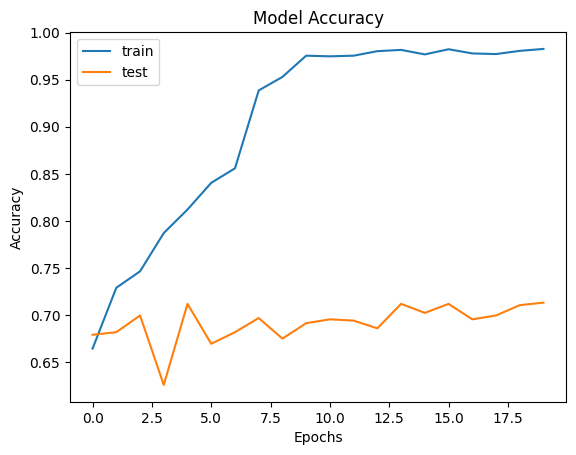

In [30]:
# summarize history for accuracy
plt.plot(H.history['accuracy'])
plt.plot(H.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


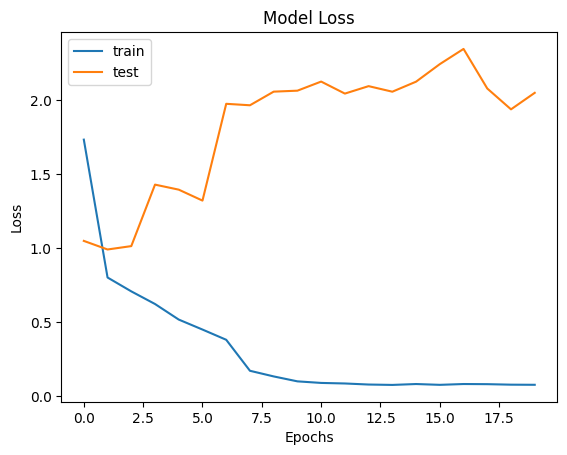

In [31]:
# summarize history for loss
plt.plot(H.history['loss'])
plt.plot(H.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Model Evaluation

In [32]:
from sklearn.metrics import classification_report,confusion_matrix

In [33]:
predictions = model.predict(X_test)
predIdxs = np.argmax(predictions, axis=1)

23/23 [==============================] - 2s 59ms/step


In [34]:
print(classification_report(Y_test, predIdxs))

              precision    recall  f1-score   support

           0       0.93      0.99      0.96       344
           1       0.55      0.41      0.47        70
           2       0.64      0.80      0.71       212
           3       0.54      0.16      0.24        45
           4       0.45      0.27      0.34        62

    accuracy                           0.77       733
   macro avg       0.62      0.53      0.54       733
weighted avg       0.75      0.77      0.74       733



Text(95.72222222222221, 0.5, 'Actual')

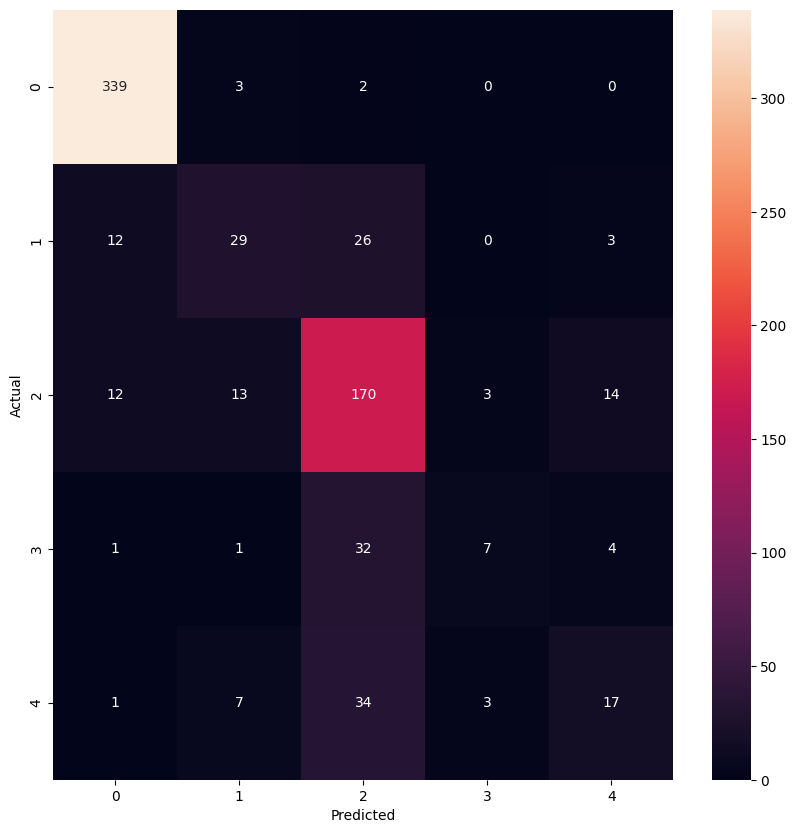

In [35]:
plt.figure(figsize=(10,10))
sns.heatmap(tf.math.confusion_matrix(Y_test, predIdxs), annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Actual')